In [2]:
from pulp import LpProblem, LpVariable, LpStatus, value, lpSum, LpMinimize
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Define the cities
cities = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'] # 'I', 'J']

N = len(cities)
max_distance = 100
max_capacity = 50

# demand of each city
D = [0, 9, 10, 38, 25, 15, 5, 10, 5, 20]

# Number of trucks
T = sum(D) // max_capacity + 1 # minimum number of trucks required to satisfy the demand

# Define the distances between the cities (distance matrix), they must not exceed 50
coordinates = {'A': (0, 0), 'B': (5, 7), 'C': (5, -5), 'D': (15, 15), 'E': (20, 10), 
               'F': (25, 12), 'G': (30, 0), 'H': (35, 5), 'I': (40, 10), 'J': (45, 0)}

distances = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i != j:
            distances[i, j] = np.sqrt((coordinates[cities[i]][0] - coordinates[cities[j]][0]) ** 2 + (coordinates[cities[i]][1] - coordinates[cities[j]][1]) ** 2)


#check if the distance matrix is symmetric
def is_symmetric(matrix):
    return (matrix.transpose() == matrix).all()
assert is_symmetric(distances), "The distance matrix is not symmetric"

# Create the optimization problem
problem = LpProblem('TSP', LpMinimize)

# Create decision variables x_ij for each truck t in T, city i in N, and city j in N
x = LpVariable.dicts('x', ((t, i, j) for t in range(T) for i in range(N) for j in range(N)), cat='Binary')

# capacity carried by t for each city i
c = LpVariable.dicts('c', ((t, i) for t in range(T) for i in range(N)), cat='Integer', lowBound=0)

# Add the subtour elimination constraints (MTZ formulation)
u = LpVariable.dicts("u", ((t, i) for t in range(T) for i in range(N)), lowBound=0, cat="Continuous")

# Objective function: Minimize the total distance
problem += lpSum(distances[i][j] * x[(t, i, j)] for t in range(T) for i in range(N) for j in range(N))


# Subtour elimination constraints
for t in range(T):
    for i in range(1, N):  # Skip the depot (city 0)
        for j in range(1, N):  # Skip the depot (city 0)
            if i != j:
                problem += u[(t, i)] - u[(t, j)] + N * x[(t, i, j)] <= N - 1


# Initialize the depot order for all trucks
for t in range(T):
    problem += u[(t, 0)] == 0

# Constraints on t
for t in range(T):
    for i in range(N):
        problem += lpSum(x[(t, i, j)] for j in range(N) if i != j) <= 1  # Leaving city `i`
        problem += lpSum(x[(t, j, i)] for j in range(N) if i != j) <= 1  # Entering city `i`
        

    # Capacity constraint
    problem += lpSum(c[(t, i)] for i in range(N)) <= max_capacity

    # distance constraint (< 100)
    problem += lpSum(distances[i][j] * x[(t, i, j)] for i in range(N) for j in range(N)) <= max_distance

    for k in range(N):
        # sum of leaving edges = sum of entering edges for each city
        problem += lpSum(x[(t, i, k)] for i in range(N) if i != k) == lpSum(x[(t, k, j)] for j in range(N) if j != k)

    problem += lpSum(x[(t, 0, j)] for j in range(N) if j != 0) == 1  # Starting city constraint

# demand satisfied constraint
for j in range(N):
    problem += lpSum(c[(t, j)] for t in range(T)) == D[j]

for t in range(T):
    for i in range(N):
        for j in range(N):
            if i == j:
                problem += x[(t, i, j)] == 0
            problem += c[(t, j)] <= max_capacity * sum(x[(t, i, j)] for i in range(N) if i != j)





# Solve the problem
problem.solve()

print('Status:', LpStatus[problem.status])
print('Objective:', value(problem.objective))
print("solvig time: ", problem.solutionTime)

Status: Optimal
Objective: 155.3418121110995
solvig time:  15.262888431549072


In [39]:
for i in range(len(cities)):
    for j in range(len(cities)):
        for t in range(T):
            if value(x[(t, i, j)]) == 1:
                print('Truck', t, ': ', cities[i], '->', cities[j], 'with capacity', value(c[(t, j)]))
                

Truck 1 :  A -> B with capacity 9.0
Truck 2 :  A -> C with capacity 10.0
Truck 0 :  A -> E with capacity 25.0
Truck 1 :  B -> D with capacity 38.0
Truck 2 :  C -> A with capacity 0.0
Truck 1 :  D -> A with capacity 0.0
Truck 0 :  E -> F with capacity 15.0
Truck 0 :  F -> G with capacity 5.0
Truck 0 :  G -> A with capacity 0.0


{0: [(0, 6, 5.0), (4, 0, 0.0), (5, 4, 20.0), (6, 7, 10.0), (7, 5, 15.0)], 1: [(0, 3, 38.0), (3, 4, 5.0), (4, 0, 0.0)], 2: [(0, 1, 9.0), (1, 2, 10.0), (2, 0, 0.0)]}


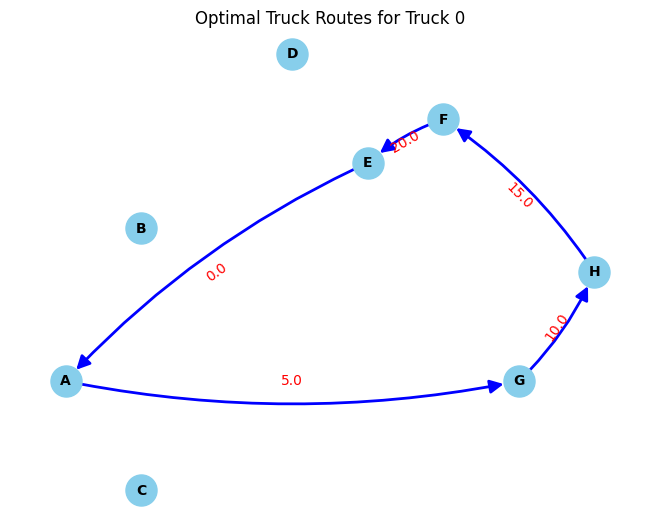

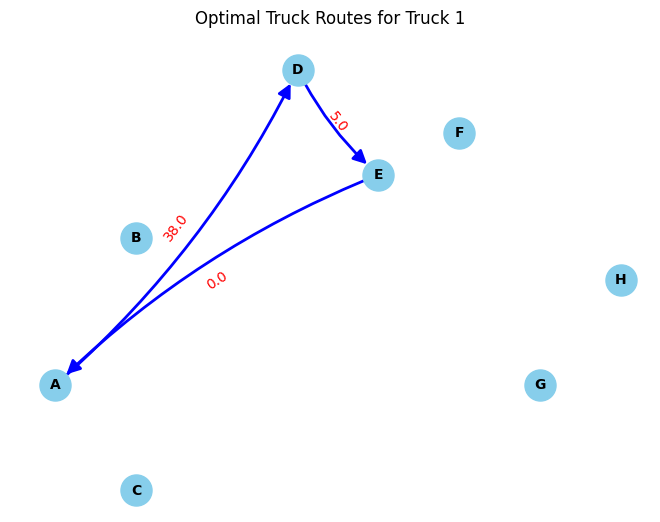

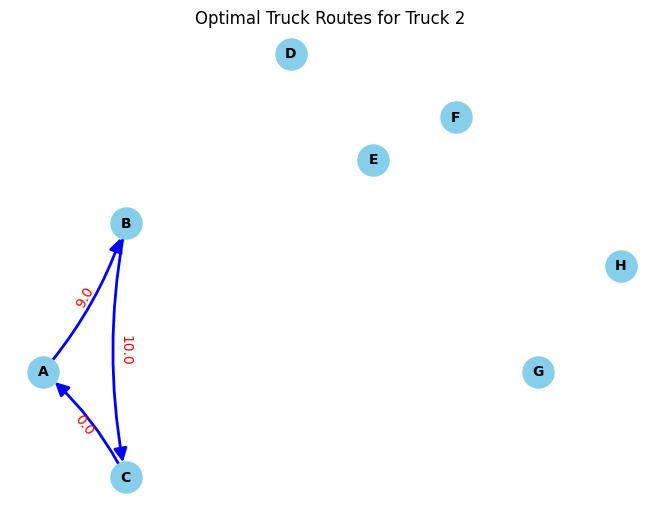

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(4)

# Define a list of colors for each truck (you can customize this)
colors = ['red', 'green', 'blue', 'yellow', 'orange']

# Function to get edges for each truck t (this assumes you have a function `edges(x)` that returns the edges)
def edges(x):
    edges_per_truck = {}
    for t in range(T):
        edges_per_truck[t] = []
        for i in range(N):
            for j in range(N):
                if value(x[(t, i, j)]) == 1:  # If the variable x[(t, i, j)] is 1, it means the truck travels from i to j
                    edges_per_truck[t].append((i, j, value(c[(t, j)])))
    return edges_per_truck

print(edges(x))
for t in range(T):
    # Create the graph
    np.random.seed(4)
    G = nx.DiGraph()
    # add nodes using the cities coordinates
    # for city in cities:
    #     G.add_node(city, pos=coordinates[city])

    G.add_nodes_from(cities)

    # Get the edges for each truck and add them to the graph with the appropriate color
    edges_per_truck = edges(x)

    # Add edges to the graph
    for edge in edges_per_truck[t]:
        G.add_edge(cities[edge[0]], cities[edge[1]], weight=distances[edge[0]][edge[1]], packages=edge[2])


    # Draw the graph with layout that respects the distances
    pos = nx.spring_layout(G, seed=42)
                                
    nx.draw(
        G, pos = coordinates,
        with_labels=True, node_size=500, node_color='skyblue',
        font_size=10, font_weight='bold', edge_color="blue", width=2,
        connectionstyle='arc3,rad=0.1', arrowsize=20, arrowstyle='-|>', arrows=True
    )

    # Draw edge labels directly on the edges
    edge_labels = nx.get_edge_attributes(G, 'packages')
  
    nx.draw_networkx_edge_labels(G, pos = coordinates,
                                  edge_labels=edge_labels, 
                                  label_pos=0.5, font_size=10, 
                                  font_color='red',
                                  bbox=dict(facecolor='white', alpha=0, edgecolor='black'))


    # Set plot title
    plt.title(f'Optimal Truck Routes for Truck {t}')
    plt.show()
